In [9]:
import os
import numpy as np
from Cryptodome.PublicKey.DSA import construct
from PIL import Image
from matplotlib import pyplot as plt
import textwrap

Empirical Coverage: 0.997169143665959


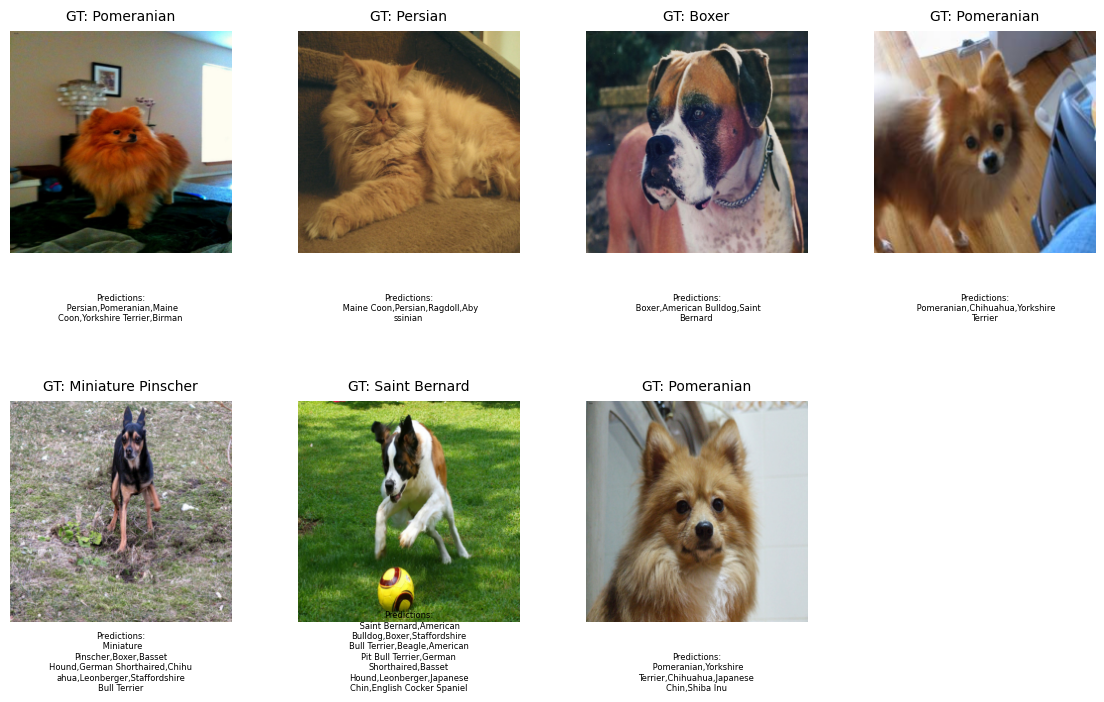

In [25]:
## Part 1 -- Use Naive Prediction

# Data preparation
softmax_outputs = np.load('softmax_outputs.npy')
correct_classes = np.load('correct_classes.npy')

# Data Split
split = 2000
calibration_softmax = softmax_outputs[:split]
calibration_labels = correct_classes[:split]
validation_softmax = softmax_outputs[split:]
validation_labels = correct_classes[split:]

# Get score 
scores = np.array([calibration_softmax[i, calibration_labels[i]] for i in range(split)])  # Retrieve the softmax score of the correct class for each example

# Calculate 1-quantile (one-tailed q?)
alpha = 0.1
q_hat = np.quantile(scores, 1-alpha)

# Construct prediction set that have cumulative score >= q_hat
def construct_prediction_set(softmax_output, q_hat):
    stored_indices = np.argsort(softmax_output)[::-1]  # Sort class by scores
    cumulative_score = 0
    predictions = []
    for idx in stored_indices:
        cumulative_score += softmax_output[idx]
        predictions.append(idx)
        if cumulative_score >= q_hat:
            break
    return predictions

# Evaluate empirical coverage
cor_preds = 0
for i in range(len(validation_softmax)):
    prediction_set = construct_prediction_set(validation_softmax[i], q_hat)
    if validation_labels[i] in prediction_set:
        cor_preds += 1
empirical_coverage = cor_preds / len(validation_softmax)
print(f'Empirical Coverage: {empirical_coverage}')

# Check naive prediction on example images
folder_path = 'example_images'
example_outputs = np.load(os.path.join(folder_path, 'model_outputs.npy'))
gt_classes = np.load(os.path.join(folder_path, 'gt_classes.npy'))
idx2cls = np.load(os.path.join(folder_path, 'idx2cls.npy'), allow_pickle=True)
cls2idx = {v: k for k, v in enumerate(idx2cls)}

selected_images = ['B0.png', 'B1.png', 'B2.png', 'B3.png', 'B15.png', 'B17.png', 'B19.png']
selected_indices = [0,1,2,3,15,17,19]
# Recalculate q_hat
example_scores = np.array([example_outputs[i, cls2idx[gt_classes[i]]] for i in range(len(example_outputs))])
#q_hat = np.quantile(example_scores, 1-alpha)
plt.figure(figsize=(14, 8))
for i, (image_name, idx) in enumerate(zip(selected_images, selected_indices)):
    image = Image.open(os.path.join(folder_path, image_name))
    gt_label = gt_classes[idx]
    example_output = example_outputs[idx]
    # Construct prediction set
    pred_set = construct_prediction_set(example_output, q_hat)
    pred_set_names = [idx2cls[i] for i in pred_set]
    
    # Plot image
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.text(0.5, 1.05, f'GT: {gt_label}', fontsize=10, ha='center', wrap=True, transform=plt.gca().transAxes)
    pred_texts = ','.join(pred_set_names)
    wrapped_text = "\n".join(textwrap.wrap(pred_texts, 30))
    plt.text(0.5, -0.3, f'Predictions:\n {wrapped_text}', fontsize=6, ha='center', wrap=True, transform=plt.gca().transAxes)
    
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [22]:
folder_path = 'example_images'
example_outputs = np.load(os.path.join(folder_path, 'model_outputs.npy'))
np.max(example_outputs[0])

0.5038687